In [ ]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!pip install -r requirements.txt
%cd ..

!wget https://judge.nitro-ai.org/download/nitro-2025/nitro-nlp/3/train_data.csv

In [ ]:
import pandas as pd

df = pd.read_csv('train_data.csv')

print(df.head())
print(df.describe())
print(df['DuckOrNoDuck'].value_counts())

   DatapointID  DuckOrNoDuck  PixelCount     BoundingBox
0            1             1        1540  137 89 212 177
1            2             0           0         0 0 0 0
2            3             1        2090  162 60 267 143
3            4             1        1408   10 207 91 277
4            5             1        2373   71 47 185 149
       DatapointID  DuckOrNoDuck   PixelCount
count  1828.000000    1828.00000  1828.000000
mean    914.500000       0.81291  1942.892779
std     527.842464       0.39009  1536.015490
min       1.000000       0.00000     0.000000
25%     457.750000       1.00000  1063.750000
50%     914.500000       1.00000  1596.500000
75%    1371.250000       1.00000  2839.500000
max    1828.000000       1.00000  8826.000000
DuckOrNoDuck
1    1486
0     342
Name: count, dtype: int64


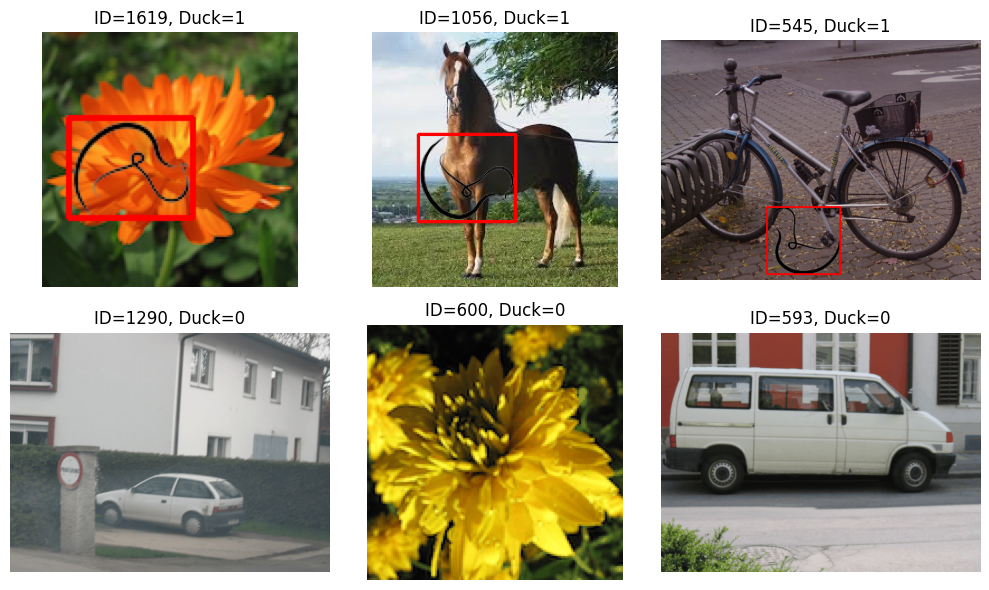

In [ ]:
import matplotlib.pyplot as plt
import cv2

# alegem cateva exemple cu rate si fara, pentru a vedea datasetul (desenam si rect pt rate)
positives = df[df['DuckOrNoDuck'] == 1].sample(3, random_state=42)['DatapointID']
negatives = df[df['DuckOrNoDuck'] == 0].sample(3, random_state=42)['DatapointID']

def show_image(id_):
    img = cv2.imread(f'images/train_dataset/{id_}.png')
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    row = df[df['DatapointID'] == id_].iloc[0]

    if row.DuckOrNoDuck == 1:
        x1,y1,x2,y2 = map(int, row.BoundingBox.split())
        cv2.rectangle(img, (x1,y1), (x2,y2), (255,0,0), 2)

    plt.imshow(img); plt.title(f"ID={id_}, Duck={row.DuckOrNoDuck}"); plt.axis('off')

plt.figure(figsize=(10,6))
for i, idx in enumerate(list(positives) + list(negatives), 1):
    plt.subplot(2, 3, i)
    show_image(idx)
plt.tight_layout()
plt.show()

In [ ]:
# this format is necessary for YOLO 

!mkdir -p /content/dataset/images/train
!mkdir -p /content/dataset/labels/train
!cp /content/train_dataset/*.png /content/dataset/images/train/
!cp /content/train_labels/*.txt /content/dataset/labels/train/
!mkdir -p /content/dataset/images/val
!mkdir -p /content/dataset/labels/val
!cp /content/test_dataset/*.png /content/dataset/images/val/

In [ ]:

# am ales sa folosesc un model YOLO pre-trained pt a prezice bbox
# dar mai intai cream labels file pentru train_dataset
import os

for _, row in df.iterrows():
    dp_id = row['DatapointID']
    duck_or_no = row['DuckOrNoDuck']
    bbox = row['BoundingBox']
    
    image_path = f"images/train_dataset/{dp_id}.png"
    label_path = f"images/train_labels/{dp_id}.txt"

    img = cv2.imread(image_path)
    height, width = img.shape[:2]
    
    if duck_or_no == 1:
        # yolo format class_id center_x center_y width height
        x1, y1, x2, y2 = map(int, bbox.strip().split())
        
        center_x = (x1 + x2) / 2 / width
        center_y = (y1 + y2) / 2 / height
        box_width = (x2 - x1) / width
        box_height = (y2 - y1) / height
        
        with open(label_path, 'w') as f:
            f.write(f"0 {center_x:.6f} {center_y:.6f} {box_width:.6f} {box_height:.6f}\n")
    else:
        open(label_path, 'w').close()

In [ ]:
#train the model :  
!python yolov5/train.py --img 640 --batch 32 --epochs 30 --data /content/data.yaml --weights yolov5s.pt --cache

# test the model :
!python yolov5/detect.py --weights /content/yolov5/runs/train/exp/weights/best.pt --source /content/val/images --save-txt --conf 0.25 --img 640

^C


In [ ]:
import os
import pandas as pd
import numpy as np
from PIL import Image
from sklearn.linear_model import LinearRegression


labels_dir = '/yolov5/runs/detect/exp4/labels'
images_dir = '/val/images'  

image_ids = []
DuckOrNoDuck = []
PixelCount = []
BoundingBox_as_string = []

train_data = pd.read_csv('train_data.csv')

train_data['PixelCount'] = pd.to_numeric(train_data['PixelCount'], errors='coerce')

X_train = []
y_train = []

for index, row in train_data.iterrows():
    if row['DatapointID'] == 501:
        break
    img_path = os.path.join(images_dir, f"{row['DatapointID']}.png")
    img = Image.open(img_path)
    img_width, img_height = img.size
    
    bbox = row['BoundingBox']
    bbox_coords = list(map(int, bbox.split()))  
    
    if len(bbox_coords) == 4:
        x1, y1, x2, y2 = bbox_coords
    else:
        x1, y1, x2, y2 = 0, 0, 0, 0  
  
    X_train.append([img_width, img_height, x1, y1, x2, y2]) 
    y_train.append(row['PixelCount']) 

X_train = np.array(X_train)
y_train = np.array(y_train)

regressor = LinearRegression()
regressor.fit(X_train, y_train)

for filename in os.listdir(images_dir):
    image_id = os.path.splitext(filename)[0]  
    label_path = os.path.join(labels_dir, f"{image_id}.txt")  

    if os.path.exists(label_path):  
        with open(label_path, 'r') as f:
            lines = f.readlines()

        if len(lines) == 0:  
            DuckOrNoDuck.append(0)
            PixelCount.append(0)
            BoundingBox_as_string.append("0 0 0 0")
        else:
            has_duck = False
            bbox_list = []
            
            for line in lines:
                cls, x_center, y_center, width, height = map(float, line.strip().split())
                if cls == 0:  
                    has_duck = True

                    img_path = os.path.join(images_dir, f"{image_id}.png")
                    img = Image.open(img_path)
                    img_width, img_height = img.size
                    
                    x1 = int((x_center - width / 2) * img_width)
                    y1 = int((y_center - height / 2) * img_height)
                    x2 = int((x_center + width / 2) * img_width)
                    y2 = int((y_center + height / 2) * img_height)
                    bbox_list.append(f"{x1} {y1} {x2} {y2}")
            
            if has_duck:
                bbox_list.sort(reverse=True, key=lambda x: x[0])  
                max_bbox = bbox_list[0]  
                x1, y1, x2, y2 = map(int, max_bbox.split(','))
                
                img_path = os.path.join(images_dir, f"{image_id}.png")
                img = Image.open(img_path)
                img_width, img_height = img.size

                img_features = np.array([[img_width, img_height, x1, y1, x2, y2]])  
                predicted_pixels = regressor.predict(img_features)  
                PixelCount.append(int(predicted_pixels[0]))
                BoundingBox_as_string.append(max_bbox)
            else:
                DuckOrNoDuck.append(0)
                PixelCount.append(0)
                BoundingBox_as_string.append("0 0 0 0")
    else:
        DuckOrNoDuck.append(0)
        PixelCount.append(0)
        BoundingBox_as_string.append("0 0 0 0")

    image_ids.append(image_id)

df1 = pd.DataFrame({'subtaskID': 1, 'datapointID': image_ids, 'answer': DuckOrNoDuck})  # Task 1 - DuckOrNoDuck
df2 = pd.DataFrame({'subtaskID': 2, 'datapointID': image_ids, 'answer': PixelCount})  # Task 2 - PixelCount
df3 = pd.DataFrame({'subtaskID': 3, 'datapointID': image_ids, 'answer': BoundingBox_as_string})  # Task 3 - BoundingBox

df_out = pd.concat([df1, df2, df3], ignore_index=True)
df_out.to_csv('final_output.csv', index=False)